<a href="https://colab.research.google.com/github/poojitharajapuram/ML-HW7/blob/main/HW7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.6 MB/s eta 0:00:00
time: 401 µs (started: 2023-12-12 20:53:45 +00:00)


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)

time: 11 s (started: 2023-12-12 20:54:38 +00:00)


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

time: 7.04 ms (started: 2023-12-12 20:55:18 +00:00)


In [4]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

100%|██████████| 170498071/170498071 [00:02<00:00, 68082512.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
time: 25.3 s (started: 2023-12-12 20:55:45 +00:00)


In [5]:
mean, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

time: 37.5 ms (started: 2023-12-12 20:56:14 +00:00)


In [6]:
cifar10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

time: 563 ms (started: 2023-12-12 20:56:38 +00:00)


In [7]:
cifar10_val = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))


time: 475 ms (started: 2023-12-12 20:56:54 +00:00)


In [8]:
first_image, label = cifar10[0]
print(first_image.shape)

torch.Size([3, 32, 32])
time: 11.2 ms (started: 2023-12-12 20:57:09 +00:00)


In [9]:
train_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False, num_workers=2)


time: 2.07 ms (started: 2023-12-12 20:58:18 +00:00)


In [10]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

time: 683 µs (started: 2023-12-12 20:58:47 +00:00)


1a

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

# model = Net().to(device)

time: 1.62 ms (started: 2023-12-12 20:59:15 +00:00)


In [12]:
model = Net().to(device)

time: 5.62 ms (started: 2023-12-12 20:59:39 +00:00)


In [13]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list


(18354, [432, 16, 1152, 8, 16384, 32, 320, 10])

time: 4.09 ms (started: 2023-12-12 20:59:52 +00:00)


In [14]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 2 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

time: 1.09 ms (started: 2023-12-12 21:00:08 +00:00)


In [15]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)


2023-12-12 21:01:12.391600 Epoch 1, Training loss 2.0680635306231507
2023-12-12 21:01:52.931984 Epoch 2, Training loss 1.797562748879728
2023-12-12 21:03:15.522334 Epoch 4, Training loss 1.5253450474165895
2023-12-12 21:04:38.091112 Epoch 6, Training loss 1.3814998115115154
2023-12-12 21:05:59.543925 Epoch 8, Training loss 1.2716535024173425
2023-12-12 21:07:21.780269 Epoch 10, Training loss 1.1938960402060652
2023-12-12 21:08:43.939458 Epoch 12, Training loss 1.136115832859293
2023-12-12 21:10:07.313606 Epoch 14, Training loss 1.0900188293450934
2023-12-12 21:11:29.596277 Epoch 16, Training loss 1.0553452937346894
2023-12-12 21:12:50.455821 Epoch 18, Training loss 1.022620889155761
2023-12-12 21:14:12.662361 Epoch 20, Training loss 0.9953090766506731
2023-12-12 21:15:35.068527 Epoch 22, Training loss 0.9690991000598653
2023-12-12 21:16:56.213134 Epoch 24, Training loss 0.948285439587615
2023-12-12 21:18:19.788839 Epoch 26, Training loss 0.9291066480109759
2023-12-12 21:19:42.015133 Ep

In [16]:
import collections

time: 675 µs (started: 2023-12-13 00:35:59 +00:00)


In [17]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    predictions = []
    exp_labels = []

    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

                predictions.extend(predicted.cpu().numpy())
                exp_labels.extend(labels.cpu().numpy())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict, predictions, exp_labels


time: 3.31 ms (started: 2023-12-13 00:36:18 +00:00)


In [18]:
accuracy, predictions, expected_labels = validate(model, train_loader, val_loader)

Accuracy train: 0.78
Accuracy val: 0.61
time: 52.9 s (started: 2023-12-13 00:36:44 +00:00)


In [19]:


precision = precision_score(predictions, expected_labels, average='macro')
recall = recall_score(predictions, expected_labels, average='macro')
cnf_matrix = confusion_matrix(predictions, expected_labels)


time: 221 ms (started: 2023-12-13 00:37:41 +00:00)


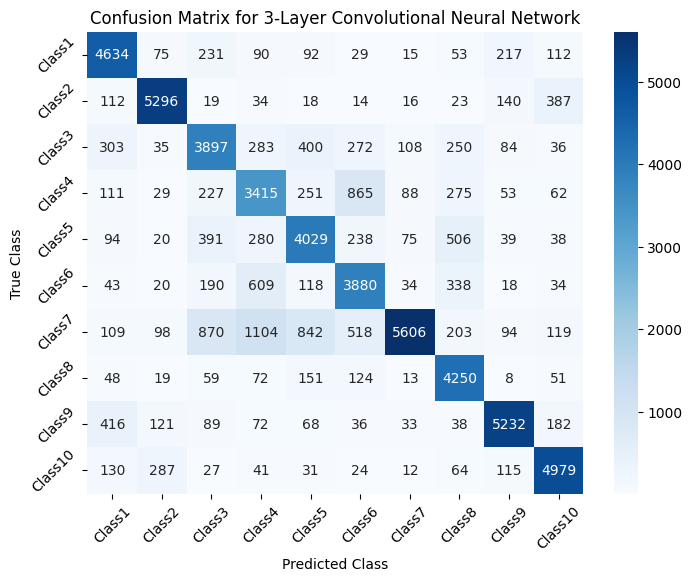

time: 1.21 s (started: 2023-12-13 04:31:17 +00:00)


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

new_class_names = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5',
                   'Class6', 'Class7', 'Class8', 'Class9', 'Class10']

plt.figure(figsize=(8, 6))

sns.heatmap(cnf_matrix, annot=True, cmap="Blues", fmt='g',
            xticklabels=new_class_names, yticklabels=new_class_names)

plt.title('Confusion Matrix for 3-Layer Convolutional Neural Network')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()


In [21]:
print(classification_report(predictions, expected_labels, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.77      0.84      0.80      5548
  automobile       0.88      0.87      0.88      6059
        bird       0.65      0.69      0.67      5668
         cat       0.57      0.64      0.60      5376
        deer       0.67      0.71      0.69      5710
         dog       0.65      0.73      0.69      5284
        frog       0.93      0.59      0.72      9563
       horse       0.71      0.89      0.79      4795
        ship       0.87      0.83      0.85      6287
       truck       0.83      0.87      0.85      5710

    accuracy                           0.75     60000
   macro avg       0.75      0.76      0.75     60000
weighted avg       0.77      0.75      0.75     60000

time: 260 ms (started: 2023-12-13 00:38:31 +00:00)


1b

In [22]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, padding=1)
        self.act3 = nn.Tanh()
        self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4 * 4 * 4, 32)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.pool3(self.act3(self.conv3(out)))
        out = out.view(-1, 4 * 4 * 4)
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out


time: 1.96 ms (started: 2023-12-13 00:39:56 +00:00)


In [23]:
model2 = Net2().to(device)

time: 2.89 ms (started: 2023-12-13 00:40:26 +00:00)


In [24]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18354, [432, 16, 1152, 8, 16384, 32, 320, 10])

time: 28.5 ms (started: 2023-12-13 00:40:45 +00:00)


In [25]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)

model2 = Net2().to(device=device)
optimizer2 = optim.SGD(model2.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer2,
    model = model2,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-12-13 00:41:50.532707 Epoch 1, Training loss 2.227428464785866
2023-12-13 00:42:36.325712 Epoch 2, Training loss 2.041189785046346
2023-12-13 00:44:07.097267 Epoch 4, Training loss 1.8631245211871994
2023-12-13 00:45:36.426565 Epoch 6, Training loss 1.6323020871338028
2023-12-13 00:47:04.144916 Epoch 8, Training loss 1.5369410411171291
2023-12-13 00:48:32.303426 Epoch 10, Training loss 1.4644280211699894
2023-12-13 00:50:00.578365 Epoch 12, Training loss 1.3947551524852548
2023-12-13 00:51:29.232203 Epoch 14, Training loss 1.334622222291844
2023-12-13 00:52:57.991160 Epoch 16, Training loss 1.29480339217064
2023-12-13 00:54:26.623110 Epoch 18, Training loss 1.2660975428036108
2023-12-13 00:55:55.474993 Epoch 20, Training loss 1.2398263139797903
2023-12-13 00:57:25.658718 Epoch 22, Training loss 1.2168194206474383
2023-12-13 00:58:53.964179 Epoch 24, Training loss 1.1977226912517986
2023-12-13 01:00:22.720809 Epoch 26, Training loss 1.1789229130348586
2023-12-13 01:01:51.513212 Epo

In [27]:
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)


time: 1.09 ms (started: 2023-12-13 04:25:15 +00:00)


In [28]:
accuracy2, predictions2, expected_labels2 = validate(model2, train_loader, val_loader)

Accuracy train: 0.69
Accuracy val: 0.64
time: 52.4 s (started: 2023-12-13 04:25:43 +00:00)


In [29]:
precision2 = precision_score(predictions2, expected_labels2, average='macro')
recall2 = recall_score(predictions2, expected_labels2, average='macro')
cnf_matrix2 = confusion_matrix(predictions2, expected_labels2)

time: 1.77 s (started: 2023-12-13 04:26:35 +00:00)


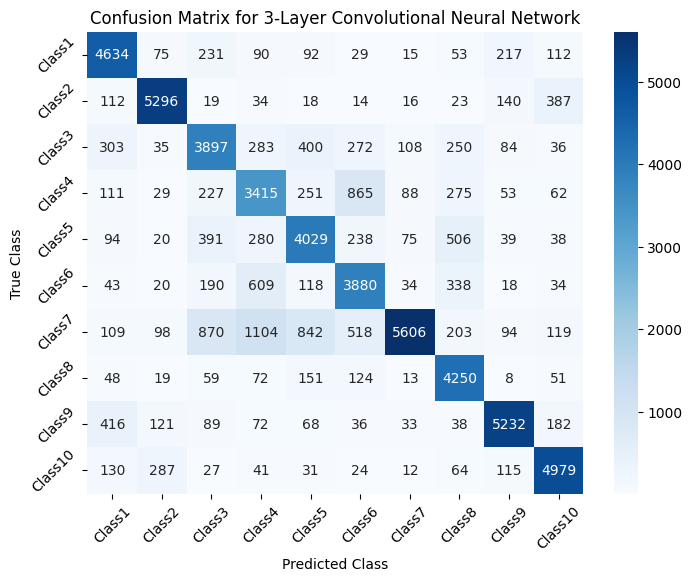

time: 1.44 s (started: 2023-12-13 04:31:58 +00:00)


In [33]:

import matplotlib.pyplot as plt
import seaborn as sns

new_class_names = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5',
                   'Class6', 'Class7', 'Class8', 'Class9', 'Class10']

plt.figure(figsize=(8, 6))

sns.heatmap(cnf_matrix, annot=True, cmap="Blues", fmt='g',
            xticklabels=new_class_names, yticklabels=new_class_names)

plt.title('Confusion Matrix for 3-Layer Convolutional Neural Network')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

In [34]:
print(classification_report(predictions2, expected_labels2, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.73      0.67      0.70      6517
  automobile       0.80      0.83      0.82      5781
        bird       0.52      0.58      0.55      5405
         cat       0.46      0.49      0.47      5678
        deer       0.60      0.65      0.62      5610
         dog       0.60      0.55      0.58      6596
        frog       0.76      0.71      0.74      6466
       horse       0.70      0.76      0.73      5508
        ship       0.83      0.76      0.79      6517
       truck       0.79      0.80      0.79      5922

    accuracy                           0.68     60000
   macro avg       0.68      0.68      0.68     60000
weighted avg       0.68      0.68      0.68     60000

time: 241 ms (started: 2023-12-13 04:33:00 +00:00)
